In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('../../data/ctr/adult_csv_10000.csv', sep=';')

In [4]:
data.head(2)

,Age,workclass,fnlwgt,education,education-num,marital,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,Income
0,20,?,287681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,36,United-States,<=50K
1,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,>50K


In [5]:
data['class'] = (data['Income']=='>50K').astype(int)

In [6]:
data.dtypes

Age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital           object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
country           object
Income            object
class              int64
dtype: object

In [7]:
def calculate_IV(data, col_name, eps=1e-7):
    if data[col_name].dtypes == 'object':
        datagroup = data.groupby([col_name])['class'].agg(['count','sum'])
    else:
        data['bin_var'] = pd.qcut(data[col_name].rank(method='first'),10)
        datagroup = data.groupby(['bin_var'])['class'].agg(['count','sum'])

    datagroup.columns = ['total', 'p']
    datagroup['n'] = datagroup['total'] - datagroup['p']
    datagroup['p_per'] = datagroup['p'] / datagroup['p'].sum()
    datagroup['n_per'] = datagroup['n'] / datagroup['n'].sum()
    datagroup['IV'] = (datagroup['p_per'] - datagroup['n_per'])*np.log((datagroup['p_per']+eps)/(datagroup['n_per']+eps))
        
    return datagroup


In [8]:
categorical_columns = []
numerical_columns = []
for col in data.columns[:-2]:
    if data[col].dtypes == 'object':
        categorical_columns.append(col)
    else:
        numerical_columns.append(col)

total_columns = categorical_columns + numerical_columns


In [9]:
IV_list = []
for col in total_columns:
    iv_data = calculate_IV(data, col)
    iv_num = round(iv_data['IV'].sum(), 3)
    dt_type = data[col].dtypes
    IV_list.append((iv_num, col, dt_type))
    
IV_list = sorted(IV_list,reverse = True)

In [10]:
for i in range(len(IV_list)):
    print (IV_list[i][0],",",IV_list[i][1],",type =",IV_list[i][2])

2.375 , Age ,type = int64
1.65 , relationship ,type = object
1.364 , marital ,type = object
0.817 , occupation ,type = object
0.768 , education ,type = object
0.668 , education-num ,type = int64
0.474 , hours-per-week ,type = int64
0.315 , sex ,type = object
0.29 , capital-gain ,type = int64
0.168 , workclass ,type = object
0.161 , country ,type = object
0.047 , race ,type = object
0.042 , capital-loss ,type = int64
0.011 , fnlwgt ,type = int64


In [11]:
data.head(2)

,Age,workclass,fnlwgt,education,education-num,marital,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,Income,class,bin_var
0,20,?,287681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,36,United-States,<=50K,0,"(2000.8, 3000.7]"
1,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,>50K,1,"(2000.8, 3000.7]"


In [16]:
total_columns

['workclass',
 'education',
 'marital',
 'occupation',
 'relationship',
 'race',
 'sex',
 'country',
 'Age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [25]:
from src.model import rfc_fit
from src.utils import LabelEncoding
from src.utils import plot_feature_importance
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score


In [14]:
enc = LabelEncoding()
enc.fit(data, categorical_columns)
data_enc = enc.transform(data)
data_enc.head(2)

,Age,workclass,fnlwgt,education,education-num,marital,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,Income,class,bin_var
0,20,0,287681,0,10,0,0,0,0,0,0,0,36,0,<=50K,0,"(2000.8, 3000.7]"
1,31,1,84154,0,10,1,1,1,0,0,0,0,38,1,>50K,1,"(2000.8, 3000.7]"


In [20]:
X_train, X_test, y_train, y_test = train_test_split(data_enc[total_columns], data_enc['class'], test_size=0.33, random_state=42)

In [21]:
X_train.head(2)

,workclass,education,marital,occupation,relationship,race,sex,country,Age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
8371,4,0,0,4,0,0,1,0,40,196456,10,0,0,40
5027,5,1,1,3,1,0,0,0,40,123306,15,0,0,45


In [23]:
rfcls = rfc_fit(X_train, y_train)

Fitting time : 0.4319911003112793


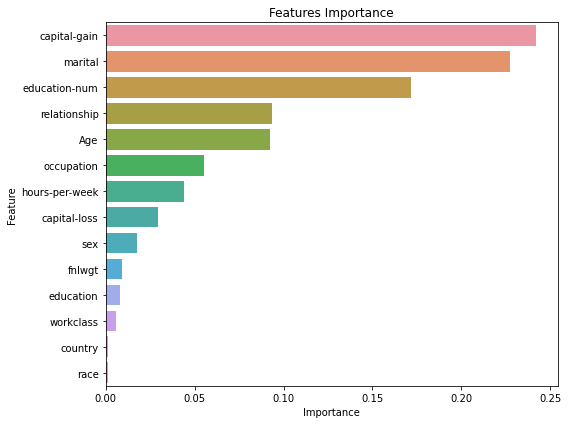

In [27]:
plot_feature_importance(rfcls, X_train.columns)

In [13]:
for col in data.columns:
    calculate_IV(data, col)

Age numerical
workclass object
fnlwgt numerical
education object
education-num numerical
marital object
occupation object
relationship object
race object
sex object
capital-gain numerical
capital-loss numerical
hours-per-week numerical
country object
Income object
class numerical
